<h3 style="text-align: center;"><strong>ESCUELA DE INGENIERÍA INFORMÁTICA - UNIVERSIDAD DE SEVILLA</strong></h3>
<h3 style="text-align: center;"><strong>GRADO EN INGENIERÍA INFORMÁTICA</strong></h3>
<h1 style="font-size: 1em; text-align: center;"><strong>MATEMÁTICA DISCRETA<br /></strong></h1>
<h2 style="font-size: 1.17em; text-align: center;"><strong>Práctica 6. Estrategias ganadoras en juegos de estrategia a tiempo real.<br /></strong></h2>
<p>En este documento práctico tomaremos como referencia el juego de estrategia <strong>Stellaris</strong>, de la empresa Paradox Interactive, con el fin de emplear el estudio de grafos en esta categoría de juegos para ejecutar posibles estrategias que nos ofrezca ventajas o incluso nos garantice la victoria.</p>
<p>Esta práctica la dividiremos en los siguientes apartados:</p>
<p> 1. <a href= "#Grafo">Representación del mapa</a>.</p>
<p> 2. <a href= "#Exploracion">¿Cómo saber si se tiene un buen comienzo y cómo ejecutar la exploración?</a></p>
<p> 3. <a href= "#Ubicacion">Ubicaciones de la capital</a>.</p>
<p> 4. <a href= "#Comercio">Estudio del comercio</a>.</p>
<p> 5. <a href= "#Conquista">Conquista eficiente</a>.</p>
<p> 6. <a href= "#Defensa">Defensa del imperio</a>.</p>
<p> </p>
<p>Al final de la práctica hay una  <a href="#cuestiones">colección de otros ejercicios propuestos.</a></p>
<p> </p>
<p>Antes de empezar con la práctica, hagamos una pequeña introducción a Stellaris para así poder entender en qué consiste el videojuego y tener contexto para poder tener una mejor toma de decisiones a la hora de plantear una estrategia:</p>
<p><strong>Stellaris</strong> es un juego de gran estrategia en tiempo real ambientado en el espacio, cuyos combates se centran más en su preparación y estrategia que en el propio combate. También hay opciones diplomáticas, tales como alianzas y acuerdos comerciales con otras razas. El jugador comienza con un solo sistema en su poder. Cualquier partida empieza con la exploración y la colonización del espacio, para más avanzada la partida sus actividades se centren en la diplomacia y el cómo gobernar un imperio.</p>
<p>En este caso, nos centraremos en el aspecto de la exploración y la conquista de sistemas.</p>

<p><strong>IMPORTANTE:</strong></p>
<p>Antes de empezar con la práctica, es de suma importancia el hecho de importar los siguientes paquetes que iremos usando a medida de que avancemos en la misma, para la ejecución de las funciones:</p>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json

/opt/sagemath-9.1/local/lib/python3.7/site-packages/networkx/algorithms/shortest_paths/weighted.py:1996: DeprecationWarning: invalid escape sequence \p
  """
/opt/sagemath-9.1/local/lib/python3.7/site-packages/networkx/algorithms/connectivity/connectivity.py:302: DeprecationWarning: invalid escape sequence \d
  """
/opt/sagemath-9.1/local/lib/python3.7/site-packages/networkx/algorithms/flow/preflowpush.py:426: DeprecationWarning: invalid escape sequence \s
  """
/opt/sagemath-9.1/local/lib/python3.7/site-packages/networkx/algorithms/flow/shortestaugmentingpath.py:298: DeprecationWarning: invalid escape sequence \m
  """
/opt/sagemath-9.1/local/lib/python3.7/site-packages/networkx/algorithms/connectivity/stoerwagner.py:94: DeprecationWarning: invalid escape sequence \l
  """


Una vez importados los paquetes, podemos empezar con la ~~conquista~~ práctica.

<h2><a name= "Grafo"></a><strong>1. Representacion del mapa</strong></h2>
<p>Como se ha mencionado antes, al comenzar una partida tendremos en nuestro poder un sistema seleccionado de manera aleatoria y tendremos que explorar (y a su vez conquistar) los sistemas <strong>adyacentes</strong> al nuestro para así ir expandiendo nuestro territorio.</p>
<p>El problema que tenemos es que no sabemos de forma gráfica cómo es la galaxia en la que nos encontramos, o dicho de la mejor forma, no sabemos cómo es el <strong>mapa</strong> de la partida, ya que éste varía completamente cuando empezamos otras partidas.</p>
<p>Para solucionar este problema haremos una <strong>representación gráfica</strong> del mapa de nuestra partida.</p>
<p>La función <em>(nombre de la función)</em> nos representará el mapa de nuestra partida como un grafo. Cada partida estará nombrada como <em>"gamestate_.json"</em>, donde '_' es un <strong>número del 0 al 9</strong>. Aunque para eso primero tendremos que leer el mapa.</p>

In [2]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [4]:
partida = lectura('data/output0.json')

<p>Una vez leído el mapa podremos ahora sí representarlo:</p>

In [13]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [12]:
print('Total de sistemas que hay en el mapa:', len(partida))
test_lectura(partida)

Total de sistemas que hay en el mapa: 394
Mostrando los tres primeros sistemas de la galaxia:
0 :  ['Bashpat', [(92, 16), (249, 14), (99, 14)], (90.86, 28.64)]
1 :  ['NAME_Trappist', [(146, 23), (62, 20), (326, 20), (43, 19), (154, 12)], (-70.84, -10.85)]
2 :  ['Jishui', [(4, 29), (355, 25), (266, 24), (248, 22), (299, 21), (174, 18)], (107.14, 133.98)]
...
Mostrando los tres últimos sistemas de la galaxia:
391 :  ['Bastamore', [(302, 18), (170, 30)], (-101.26, -245.93)]
392 :  ['Ijax', [(78, 25), (97, 19), (163, 29)], (22.03, 182.22)]
393 :  ['Witzen', [(193, 16.25289)], (132.4183, 279.02054)]


---
descripcion de lo previo

In [15]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    return grafo

In [36]:
mapa = genera_grafo(partida)

<p>Gargamos el grafo sólo con grados y aristas</p>

In [17]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [19]:
test_genera_grafo(partida)

0 : [92, 249, 99]
1 : [146, 62, 326, 43, 154]
2 : [4, 355, 266, 248, 299, 174]
...
391 : [170, 302]
392 : [78, 97, 163]
393 : [193]


---
<p>Pesos del mapa</p>

In [20]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [37]:
pesos_mapa = adjudica_pesos(mapa, partida)

In [22]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [23]:
test_adjudica_pesos(mapa, partida)

0 : [(92, 16), (249, 14), (99, 14)]
1 : [(146, 23), (62, 20), (326, 20), (43, 19), (154, 12)]
2 : [(4, 29), (355, 25), (266, 24), (248, 22), (299, 21), (174, 18)]
...
391 : [(302, 18), (170, 30)]
392 : [(78, 25), (163, 29), (97, 19)]
393 : [(193, 16.25289)]


---
<p>Posiciones del mapa</p>

In [24]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [38]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

In [26]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [27]:
test_adjudica_posiciones(mapa, partida)

0 : (90.86, 28.64)
1 : (-70.84, -10.85)
2 : (107.14, 133.98)
...
391 : (-101.26, -245.93)
392 : (22.03, 182.22)
393 : (132.4183, 279.02054)


---
<p>Etiquetas del mapa</p>

In [28]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [39]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

In [30]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

In [31]:
test_adjudica_etiquetas(mapa, partida)

0 : Bashpat
1 : NAME_Trappist
2 : Jishui
...
391 : Bastamore
392 : Ijax
393 : Witzen


<p>Como se puede observar (y como podrás suponer), el grafo que devuelve la función <em>(nombre de la función)</em>, impreso en varios diccionarios, es el mapa de la galaxia de tu partida, sin filtros. A simple vista el grafo no dice nada, simplemente proyecta los <strong>sistemas de la galaxia</strong> (vértices) y las <strong>conexiones que existen entre estas</strong> (aristas).</p>
<p>La siguiente sucesión de funciones nos representará el mapa con información extra:</p>
<p>1) Mapa simple</p>

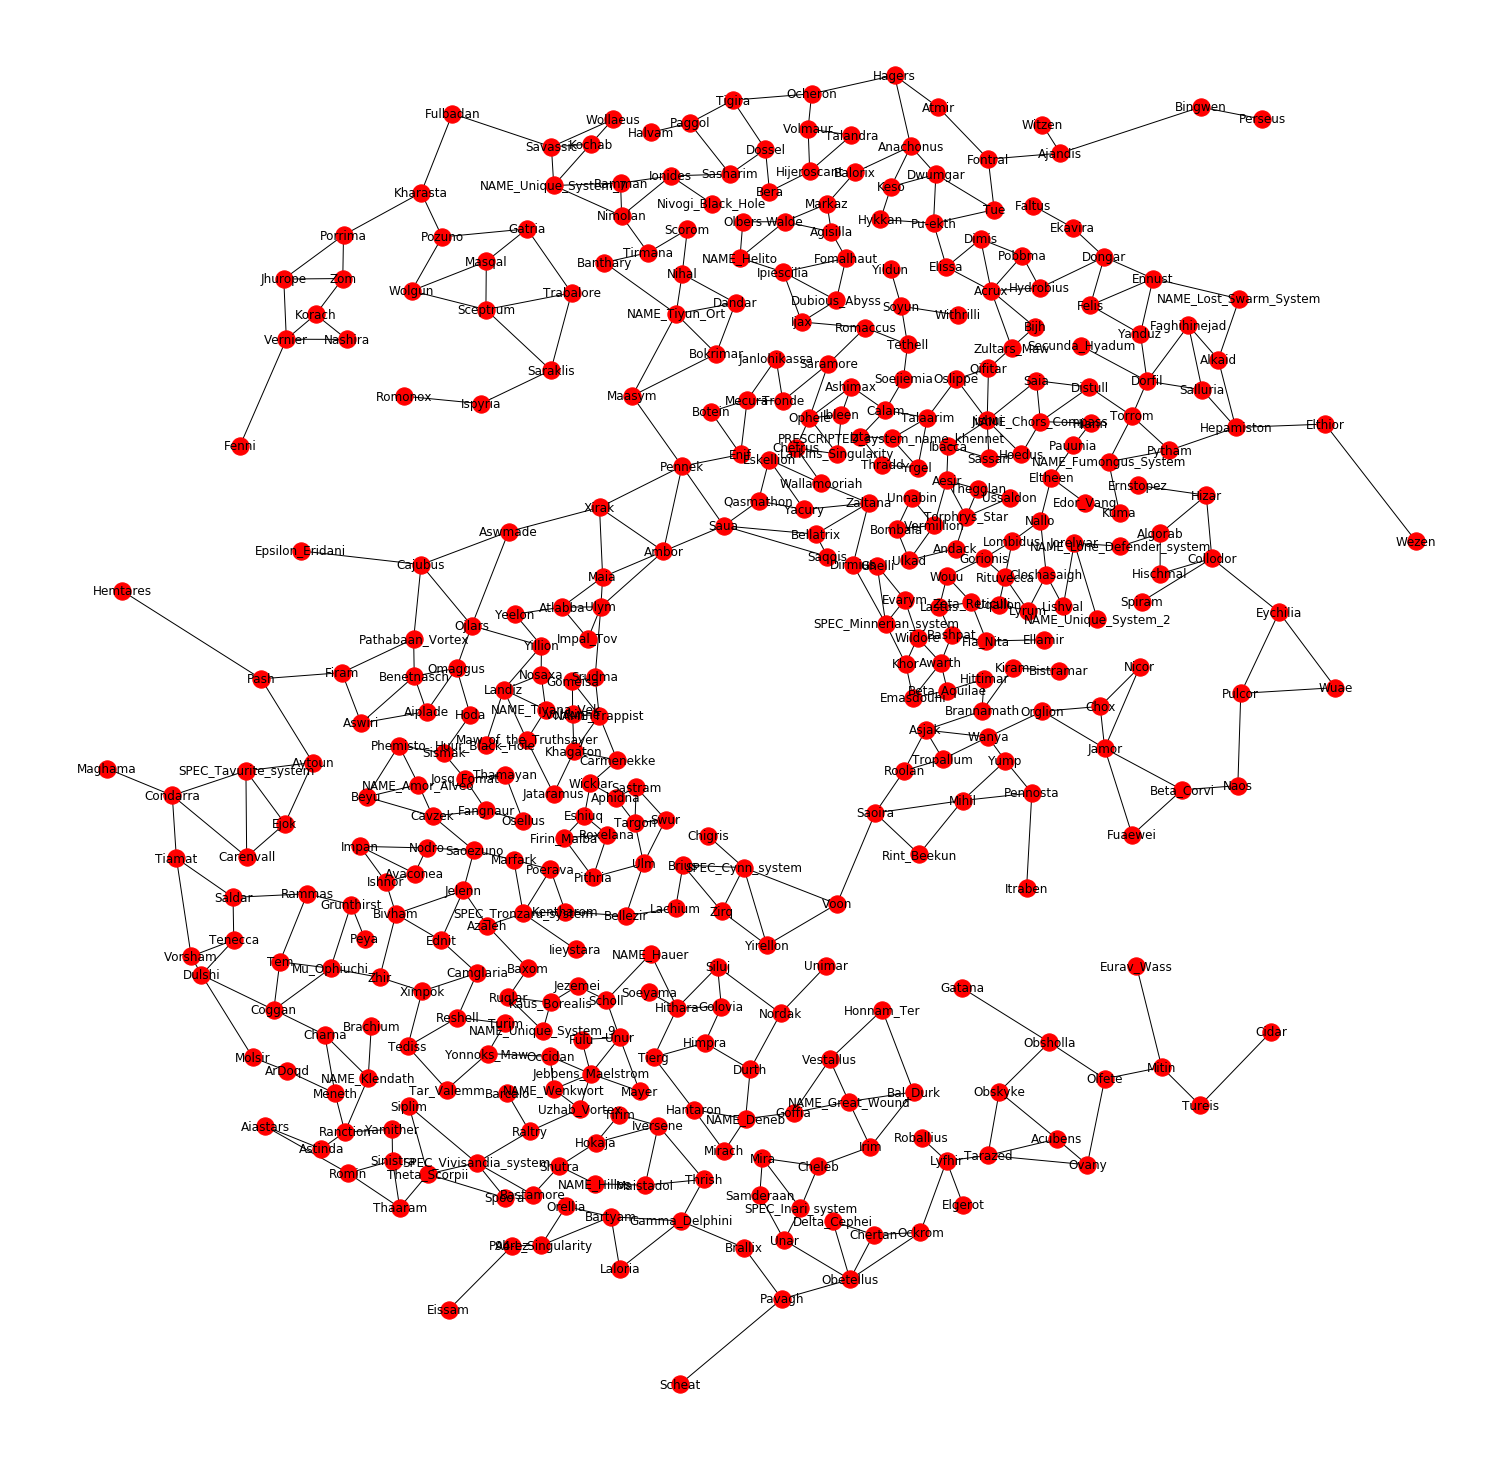

In [64]:
posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
plt.figure(figsize=(20, 20))
nx.draw(mapa_completo, pos=posiciones, labels=nx.get_node_attributes(mapa_completo, "Label"), font_size=12)

<p>2) Mapa representado mediante los pesos</p>

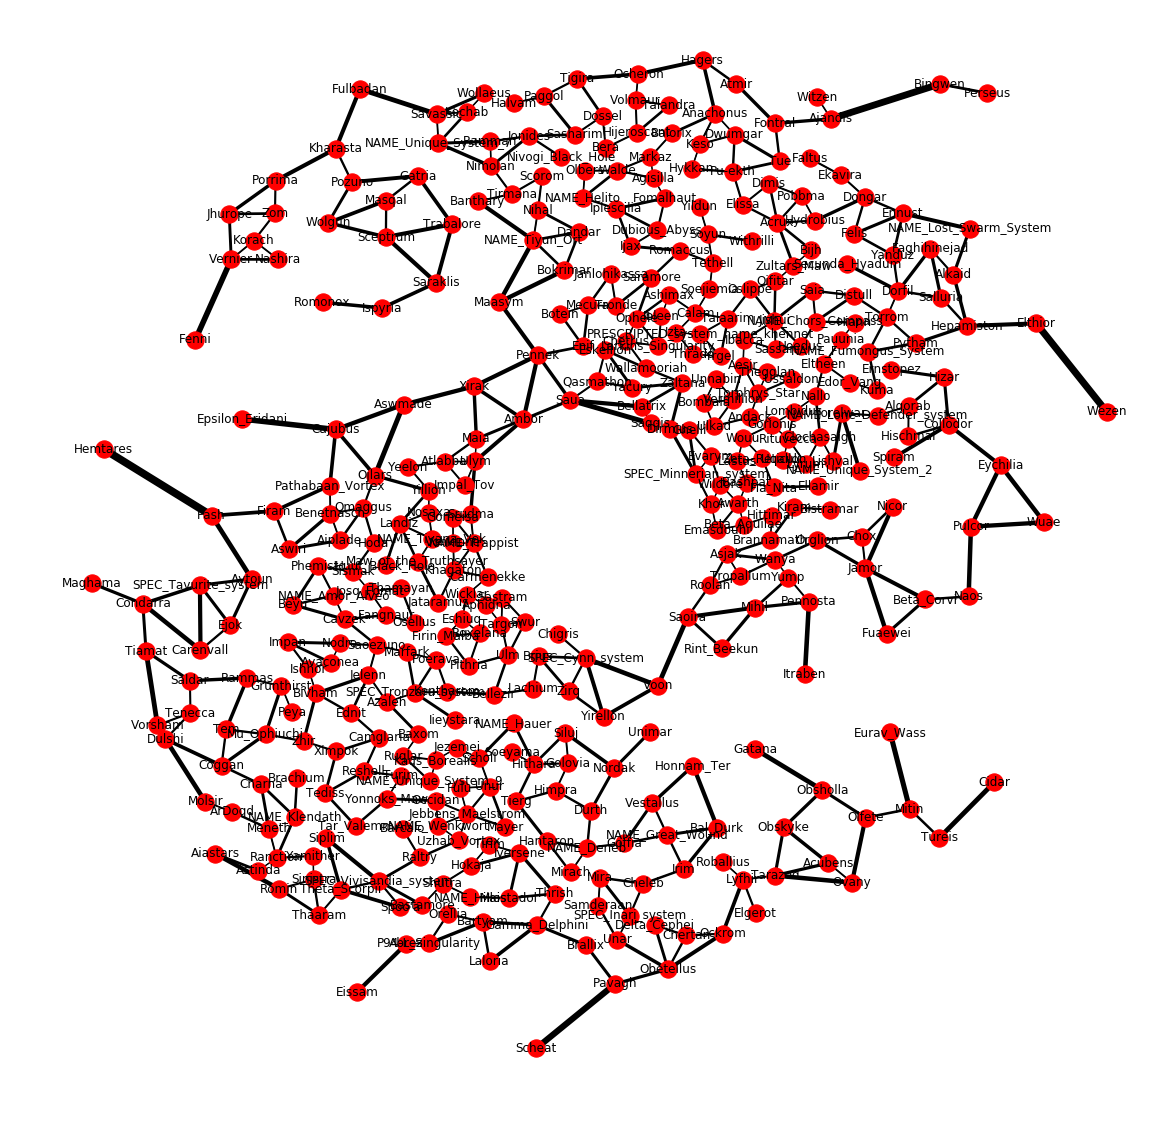

In [73]:
posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
plt.figure(figsize=(20, 20))
edge_widths = [mapa_completo[u][v]['weight']/10 for u, v in mapa_completo.edges]
nx.draw_networkx_edges(mapa_completo, pos=posiciones, width=edge_widths)
nx.draw(mapa_completo, pos=posiciones, labels=nx.get_node_attributes(mapa_completo, "Label"), font_size=12)

<p>3) Mapa por países</p>

---
<h2><a name="Exploracion"></a><strong>2. ¿Cómo saber si se tiene un buen comienzo y cómo ejecutar la exploración?</strong></h2>
<p>Sabiendo ya la forma que tiene nuestra galaxia y cómo funciona, podremos ubicarnos en ésta y plantear ya nuestra estrategia para comenzar con nuestra expansión por el espacio.</p>
<p>Sólo hay una variable que hace que a la hora de tomar ciertas decisiones hagamos una cosa u otra. Así es, hablamos del <strong>comienzo</strong>.</p>
<p>Que hayamos empezado de <em>x</em> manera en la galaxia implica en nuestra manera de explorar y reunir información suficiente para conquistar o no ciertos sistemas y así extender nuestros dominios de la <strong>manera más eficiente</strong>. Una mala decisión puede acabar en una posible caída de nuestro imperio por posición estratégica.</p>
<p>Para la función <em></em>

<h2><a name="Ubicacion"></a><strong>3. Ubicaciones de la capital</strong></h2>
<p>Ahora que conocemos nuestra galaxia y nos hemos podido abrir paso extendiendo nuestros dominios, llega un punto en el que debemos ubicar aquel sistema que será la <strong>capital</strong> de nuestro <strong>futuro imperio</strong>. El problema se basa en qué sistema o por qué lugar nos vendría bien situar nuestra capital, que esté lo más centrado posible para poder llegar rápidamente a cualquier lugar conquistado o incluso para poder defenderlo fácilemente de cualquier ataque enemigo.</p>
<p>Nos centraremos más en encontrar los sistemas perfectos para asignarles nuestra capital.</p>
<p>Mediante la función <em>mejor_opcion</em> podremos ver los mejores lugares del imperio para colocar una capital.</p>

LÓGICA PARA ABORDAR EL PROBLEMA

Una manera lógica de averiguar cuales son las mejores opciones y cuales las peores es con el centro y la periferia. Al ser los de la periferia los más dificiles de acceder desde dentro de tu imperio, es lógico que sean la peor opción. Justo lo contrario que pasa con el centro


TypeError: float() argument must be a string or a number, not 'dict'

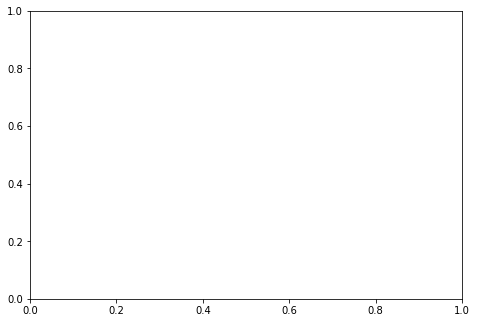

In [79]:
centro = nx.center(mapa_completo)
periferia = nx.periphery(mapa_completo)

colores={'green':centro,'red':periferia}
nx.draw(mapa_completo, pos=posiciones, labels=nx.get_node_attributes(mapa_completo, "Label"), font_size=12, node_color=colores)

MEJOR SOLUCIÓN

Como es posible que salgan demasiadas posibilidades, para poder decidir la mejor capital, eliminaremos los nodos de la periferia ya que al ser los más dificiles de acceder, son los que más posibilidades tienen de ser conquistados. Así en caso de ser conquistados asegurarnos que la capital sigue estando en un punto facilmente defendible.

In [ ]:
def mejor_opcion(g):
    """
    Encuentra iterativamente el centro de un grafo al eliminar vértices periféricos
    hasta que el tamaño del centro sea igual a 1 o se encuentre un conjunto minimo a escoger

    Parameters:
        - g: Grafo de entrada.

    Returns:
        Un conjunto de vértices que constituyen el centro del grafo.
    """
    
    # Se crea una copia del grafo original para evitar modificar el grafo original
    G = g.copy()
    
    # Se ejecuta un bucle mientras el tamaño del centro del grafo no sea igual a 1, es decir, un unico nodo importante
    while not len(G.center())==1:
        # Se verifica si el conjunto de vértices periféricos es vacío o si el radio es igual al diámetro, para saber si hemos acabado
        if not (len(G.periphery()) == 0 or G.radius() == G.diameter()):
            # En caso afirmativo, se itera sobre los vértices periféricos y se elimina cada uno de ellos
            for v in G.periphery():
                G.delete_vertex(v)
        else:
            # Si no se cumple la condición anterior, se rompe el bucle
            break
    return G.center()

In [ ]:
mejor_opcion(G)

<p>No hay mejor lugar para colocar nuestra capital que en un sistema el cuál se puedan <strong>acceder</strong> a todos los lugares de nuestro imperio de una manera más <strong>eficiente</strong> y <strong>rápida</strong>, sin perder nuestro tiempo en defendernos o incluso enviar el apoyo de nuestras tropas a la hora de conquistar.</p>
<p>Para poder localizar el mejor sistema donde instaurar la capital...</p>

<h2><a name="Comercio"></a><strong>4. Estudio del comercio</strong>

<h2><a name="Conquista"></a><strong>5. Conquista eficiente</strong></h2>

<h2><a name="Defensa"></a><strong>6. Defensa del imperio</strong></h2>